# Customer Segmentation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import plotly.express as ex
import plotly.graph_objects as go

from kneed import KneeLocator

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Get data

In [4]:
df = pd.read_csv('bank_transactions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [5]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


## Data cleaning

In [6]:
df.head(10)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
5,T6,C1536588,8/10/72,F,ITANAGAR,53609.20,2/8/16,173940,676.00
6,T7,C7126560,26/1/92,F,MUMBAI,973.46,2/8/16,173806,566.00
7,T8,C1220223,27/1/82,M,MUMBAI,95075.54,2/8/16,170537,148.00
8,T9,C8536061,19/4/88,F,GURGAON,14906.96,2/8/16,192825,833.00
9,T10,C6638934,22/6/84,M,MUMBAI,4279.22,2/8/16,192446,289.11


In [7]:
def check(df):
    a = []
    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()
        null = df[col].isna().sum()
        a.append([col,dtype,nunique,null])

    a = pd.DataFrame(a)
    a.columns = ['column','dtype','nunique','null']
    return a


In [8]:
check(df)

,column,dtype,nunique,null
0,TransactionID,object,1048567,0
1,CustomerID,object,884265,0
2,CustomerDOB,object,17254,3397
3,CustGender,object,3,1100
4,CustLocation,object,9355,151
5,CustAccountBalance,float64,161328,2369
6,TransactionDate,object,55,0
7,TransactionTime,int64,81918,0
8,TransactionAmount (INR),float64,93024,0


In [9]:
df.dropna(inplace=True)

In [10]:
check(df)

,column,dtype,nunique,null
0,TransactionID,object,1041614,0
1,CustomerID,object,879358,0
2,CustomerDOB,object,17233,0
3,CustGender,object,3,0
4,CustLocation,object,9275,0
5,CustAccountBalance,float64,160723,0
6,TransactionDate,object,55,0
7,TransactionTime,int64,81855,0
8,TransactionAmount (INR),float64,92391,0


In [11]:
df.duplicated().sum()

0

In [12]:
#Convert CustomerDOB and TransactionDate from string to datetime format

df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

C:\Users\walde\AppData\Local\Temp\ipykernel_5916\1268881537.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])
C:\Users\walde\AppData\Local\Temp\ipykernel_5916\1268881537.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1041614 non-null  object        
 1   CustomerID               1041614 non-null  object        
 2   CustomerDOB              1041614 non-null  datetime64[ns]
 3   CustGender               1041614 non-null  object        
 4   CustLocation             1041614 non-null  object        
 5   CustAccountBalance       1041614 non-null  float64       
 6   TransactionDate          1041614 non-null  datetime64[ns]
 7   TransactionTime          1041614 non-null  int64         
 8   TransactionAmount (INR)  1041614 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 79.5+ MB


In [14]:
check(df)

,column,dtype,nunique,null
0,TransactionID,object,1041614,0
1,CustomerID,object,879358,0
2,CustomerDOB,datetime64[ns],17233,0
3,CustGender,object,3,0
4,CustLocation,object,9275,0
5,CustAccountBalance,float64,160723,0
6,TransactionDate,datetime64[ns],55,0
7,TransactionTime,int64,81855,0
8,TransactionAmount (INR),float64,92391,0


In [15]:
#Calculate age of customer

df['CustomerAge'] = df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year

In [16]:
check(df)

,column,dtype,nunique,null
0,TransactionID,object,1041614,0
1,CustomerID,object,879358,0
2,CustomerDOB,datetime64[ns],17233,0
3,CustGender,object,3,0
4,CustLocation,object,9275,0
5,CustAccountBalance,float64,160723,0
6,TransactionDate,datetime64[ns],55,0
7,TransactionTime,int64,81855,0
8,TransactionAmount (INR),float64,92391,0
9,CustomerAge,int32,100,0


In [17]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,22
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,-41
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,20
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,43
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,28


In [18]:
df.drop(columns=['TransactionTime'], inplace=True)

In [19]:
check(df)

,column,dtype,nunique,null
0,TransactionID,object,1041614,0
1,CustomerID,object,879358,0
2,CustomerDOB,datetime64[ns],17233,0
3,CustGender,object,3,0
4,CustLocation,object,9275,0
5,CustAccountBalance,float64,160723,0
6,TransactionDate,datetime64[ns],55,0
7,TransactionAmount (INR),float64,92391,0
8,CustomerAge,int32,100,0


In [20]:
df.CustGender.value_counts()

CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [21]:
df.drop(df[df['CustGender']=='T'].index, inplace=True)

In [22]:
df.CustGender.value_counts()

CustGender
M    760978
F    280635
Name: count, dtype: int64

In [23]:
num_col = df.select_dtypes(include=np.number)

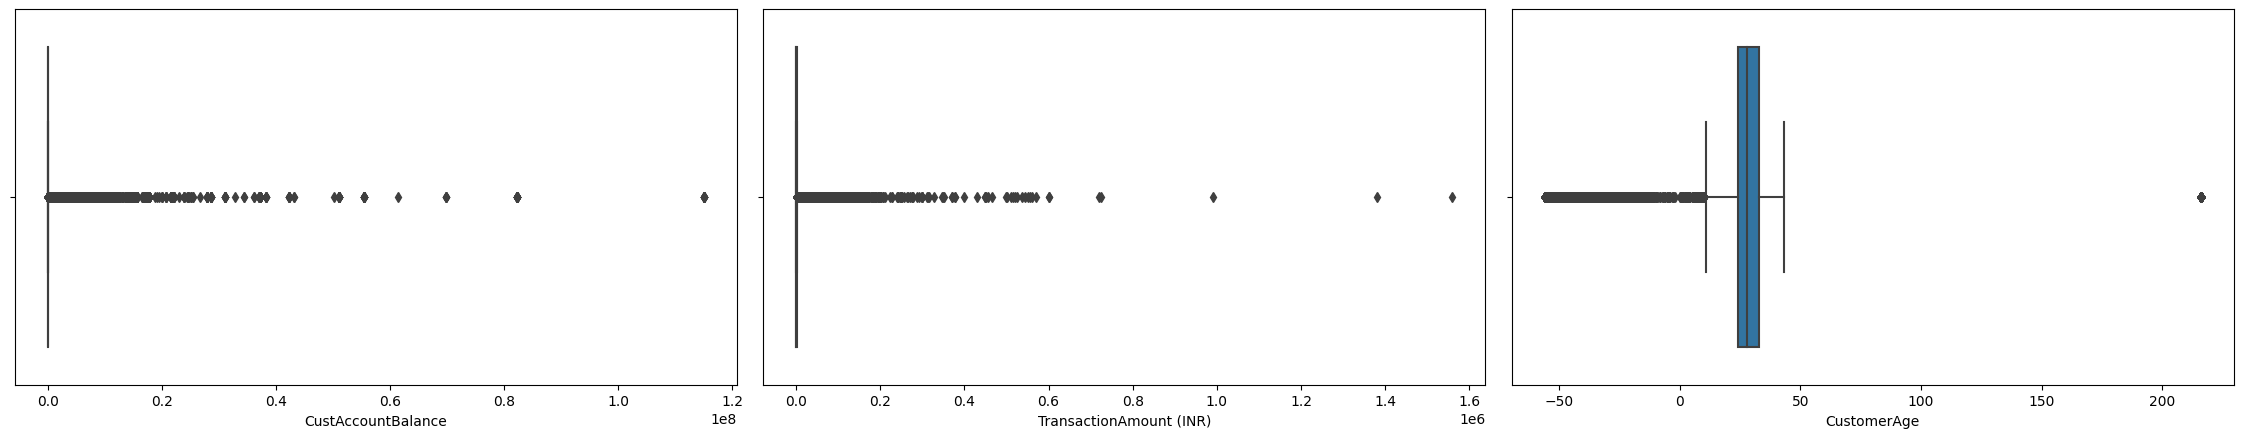

In [24]:
plt.figure(figsize=(30,30))
for index, col in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=col)

plt.tight_layout(pad=1.0)

In [25]:
df[df['CustomerAge'] > 200]['CustomerAge'].value_counts()

CustomerAge
216    56291
Name: count, dtype: int64

In [26]:
df.drop(df[df['CustomerAge'] > 200].index, inplace=True)

In [27]:
num_col = df.select_dtypes(include=np.number)

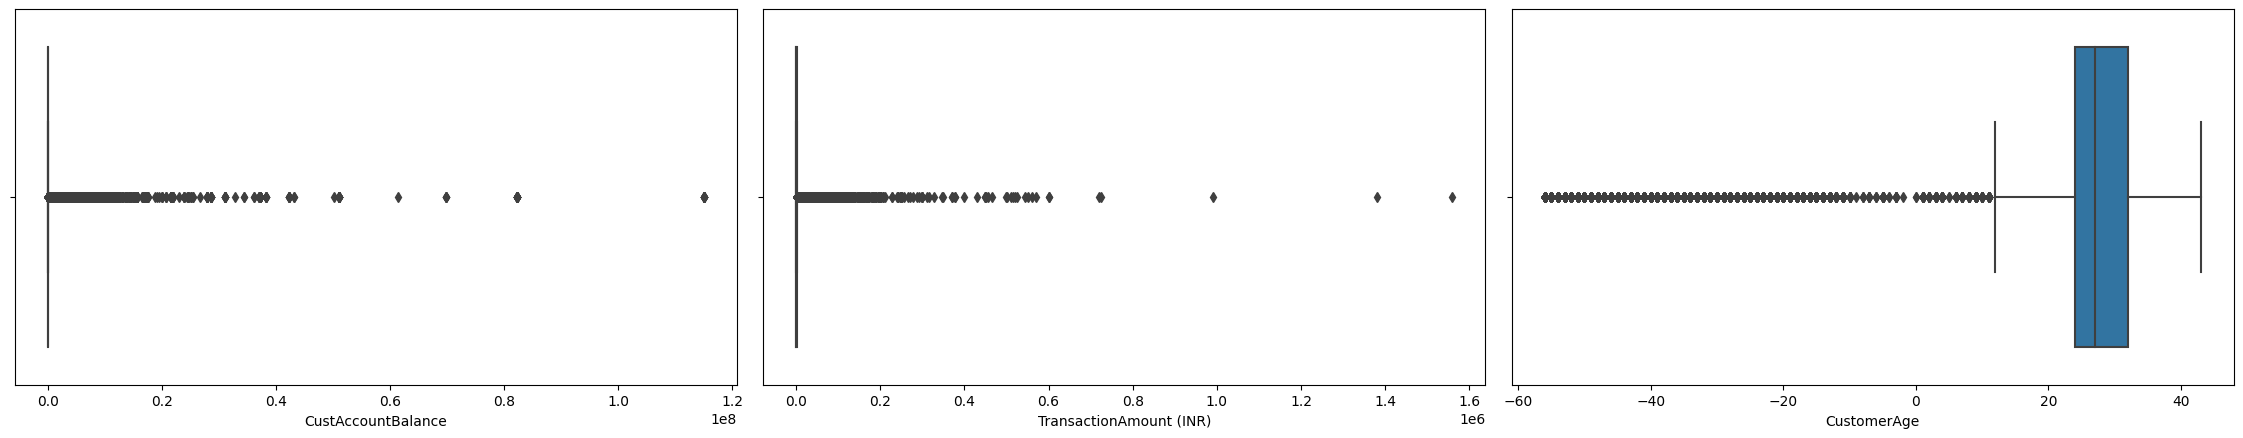

In [28]:
plt.figure(figsize=(30,30))
for index, col in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=col)

plt.tight_layout(pad=1.0)

## Let's perform RFM

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionAmount (INR)  985322 non-null  float64       
 8   CustomerAge              985322 non-null  int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 71.4+ MB


In [30]:
df['TransactionDateFirst'] = df['TransactionDate']  #First transaction date
df['TransactionDateLast'] = df['TransactionDate']   #Last transaction date

In [31]:
rfm_df = df.groupby('CustomerID').agg(
    {
        'TransactionID': 'count',
        'CustGender': 'first',
        'CustLocation': 'first',
        'CustAccountBalance': 'mean',
        'TransactionAmount (INR)': 'mean',
        'CustomerAge': 'median',
        'TransactionDateFirst': 'min',
        'TransactionDateLast': 'max',
        'TransactionDate': 'median'
    }
)

In [32]:
rfm_df = rfm_df.reset_index()
rfm_df.head()

,CustomerID,TransactionID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDateFirst,TransactionDateLast,TransactionDate
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-08,2016-09-26,2016-09-17
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-01-08,2016-07-08,2016-04-08
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18


In [33]:
rfm_df.rename(columns={'TransactionID': 'Frequency'}, inplace=True)

In [34]:
rfm_df['Recency'] = rfm_df['TransactionDateLast'] - rfm_df['TransactionDateFirst']

In [35]:
rfm_df['Recency'] = rfm_df['Recency'].astype(str)

In [36]:
rfm_df.head()

,CustomerID,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDateFirst,TransactionDateLast,TransactionDate,Recency
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-08,2016-09-26,2016-09-17,18 days
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14,0 days
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-01-08,2016-07-08,2016-04-08,182 days
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15,0 days
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18,0 days


In [37]:
rfm_df['Recency'] = rfm_df['Recency'].apply(lambda x: x.split()[0])

In [38]:
rfm_df['Recency'] = rfm_df['Recency'].astype(int)

In [39]:
#Conveerting 0 recency to 1

def ref(a):
    if a == 0:
        return 1
    else:
        return a

In [40]:
rfm_df['Recency'] = rfm_df['Recency'].apply(ref)

In [41]:
rfm_df.head()

,CustomerID,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDateFirst,TransactionDateLast,TransactionDate,Recency
0,C1010011,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-08,2016-09-26,2016-09-17,18
1,C1010012,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,2016-08-14,2016-08-14,1
2,C1010014,2,F,MUMBAI,100112.950,727.5,28.0,2016-01-08,2016-07-08,2016-04-08,182
3,C1010018,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,2016-09-15,2016-09-15,1
4,C1010024,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,2016-08-18,2016-08-18,1


In [42]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerID               839081 non-null  object        
 1   Frequency                839081 non-null  int64         
 2   CustGender               839081 non-null  object        
 3   CustLocation             839081 non-null  object        
 4   CustAccountBalance       839081 non-null  float64       
 5   TransactionAmount (INR)  839081 non-null  float64       
 6   CustomerAge              839081 non-null  float64       
 7   TransactionDateFirst     839081 non-null  datetime64[ns]
 8   TransactionDateLast      839081 non-null  datetime64[ns]
 9   TransactionDate          839081 non-null  datetime64[ns]
 10  Recency                  839081 non-null  int64         
dtypes: datetime64[ns](3), float64(3), int64(2), object(3)
memory usage: 70.4+ MB


In [43]:
rfm_df.rename(columns={'TransactionAmount (INR)': 'Monetory'}, inplace=True)

In [44]:
rfm_df.drop(columns=['CustomerID','TransactionDateFirst','TransactionDateLast'],inplace=True)

In [45]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Frequency           839081 non-null  int64         
 1   CustGender          839081 non-null  object        
 2   CustLocation        839081 non-null  object        
 3   CustAccountBalance  839081 non-null  float64       
 4   Monetory            839081 non-null  float64       
 5   CustomerAge         839081 non-null  float64       
 6   TransactionDate     839081 non-null  datetime64[ns]
 7   Recency             839081 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 51.2+ MB


In [46]:
num_col = rfm_df.select_dtypes(include=np.number)

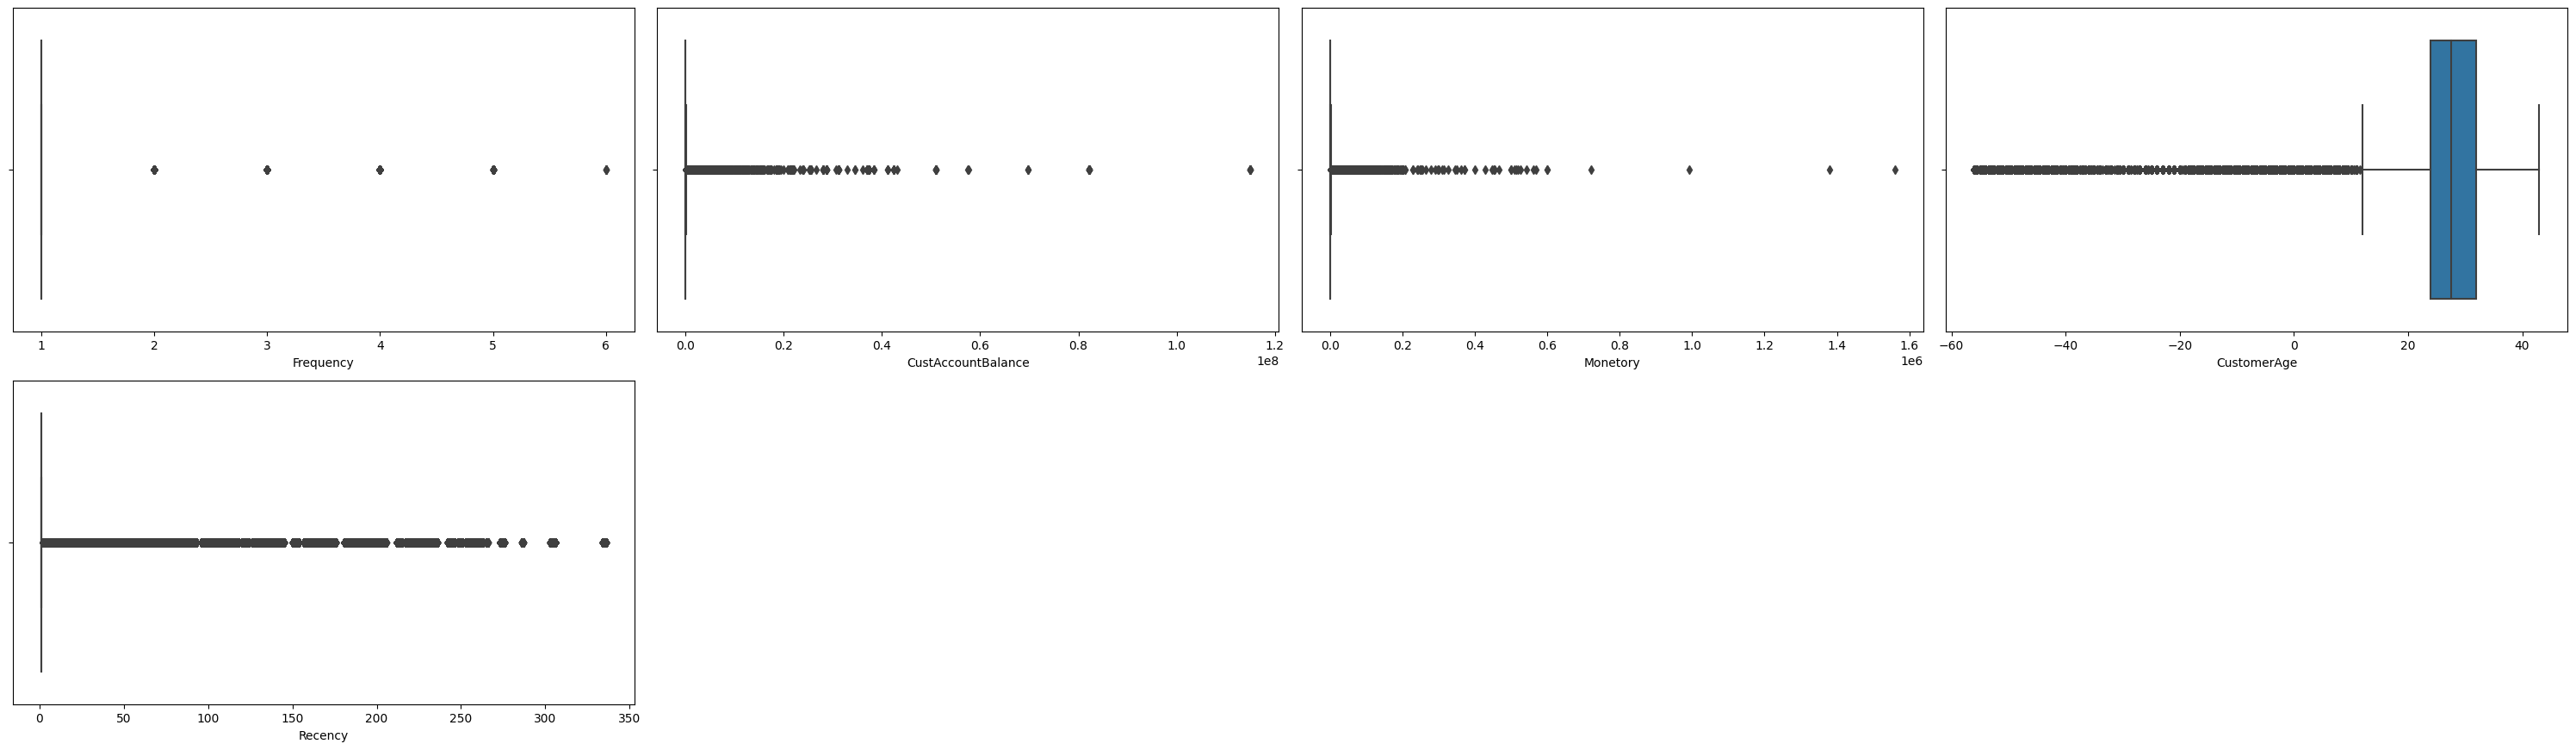

In [47]:
plt.figure(figsize=(30,30))
for index, col in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=col)

plt.tight_layout(pad=1.0)

In [48]:
rfm_df.describe()

,Frequency,CustAccountBalance,Monetory,CustomerAge,TransactionDate,Recency
count,839081.000000,8.390810e+05,8.390810e+05,839081.000000,839081,839081.000000
mean,1.174287,1.058545e+05,1.453624e+03,22.574714,2016-07-25 20:32:16.587289856,15.132148
min,1.000000,0.000000e+00,0.000000e+00,-56.000000,2016-01-08 00:00:00,1.000000
25%,1.000000,5.366190e+03,1.800000e+02,24.000000,2016-06-09 00:00:00,1.000000
50%,1.000000,1.768220e+04,4.750000e+02,27.500000,2016-08-19 00:00:00,1.000000
75%,1.000000,5.723652e+04,1.175730e+03,32.000000,2016-09-09 00:00:00,1.000000
max,6.000000,1.150355e+08,1.560035e+06,43.000000,2016-12-09 00:00:00,336.000000
std,0.435129,7.862524e+05,6.045200e+03,21.249268,NaN,45.535132


In [49]:
rfm_df['R_quartile'] = pd.cut(rfm_df['Recency'],4,labels=['1','2','3','4'])
rfm_df['F_quartile'] = pd.cut(rfm_df['Frequency'],4,labels=['4','3','2','1'])
rfm_df['M_quartile'] = pd.cut(rfm_df['Monetory'],4,labels=['4','3','2','1'])

In [50]:
rfm_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetory,CustomerAge,TransactionDate,Recency,R_quartile,F_quartile,M_quartile
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18,1,4,4
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1,1,4,4
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182,3,4,4
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1,1,4,4
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1,1,4,4


In [51]:
rfm_df['R_quartile'].value_counts()

R_quartile
1    780442
2     32336
3     22203
4      4100
Name: count, dtype: int64

In [52]:
rfm_df['F_quartile'].value_counts()

F_quartile
4    823323
3     14291
2      1353
1       114
Name: count, dtype: int64

In [53]:
rfm_df['M_quartile'].value_counts()

M_quartile
4    839060
3        18
1         2
2         1
Name: count, dtype: int64

In [54]:
rfm_df['RFM_Score'] = rfm_df.R_quartile.astype(str)+rfm_df.F_quartile.astype(str)+rfm_df.M_quartile.astype(str)

In [55]:
rfm_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetory,CustomerAge,TransactionDate,Recency,R_quartile,F_quartile,M_quartile,RFM_Score
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18,1,4,4,144
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1,1,4,4,144
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182,3,4,4,344
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1,1,4,4,144
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1,1,4,4,144


In [56]:
rfm_df[rfm_df['RFM_Score']=='114'].sort_values('Monetory', ascending=False)

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetory,CustomerAge,TransactionDate,Recency,R_quartile,F_quartile,M_quartile,RFM_Score
11238,5,M,UDHAMPUR,21573.008000,7175.000,27.0,2016-08-27,7,1,1,4,114
15391,5,M,GURGAON,23952.336000,5640.400,22.0,2016-08-31,82,1,1,4,114
528319,5,F,KOLKATA,58555.278000,2459.300,33.0,2016-08-23,62,1,1,4,114
231138,5,M,VIJAYAWADA,27386.838000,2336.872,26.0,2016-09-08,32,1,1,4,114
670384,5,M,NEW DELHI,286493.558000,2324.780,28.0,2016-08-22,23,1,1,4,114
668490,5,M,MUMBAI,289490.620000,1515.300,-51.0,2016-09-14,67,1,1,4,114
466827,5,M,CHENNAI,36689.630000,1120.064,35.0,2016-08-16,18,1,1,4,114
534220,5,F,KOLKATA,27104.212000,1097.220,28.0,2016-09-18,40,1,1,4,114
683630,5,F,KOLKATA,173077.734000,1004.800,28.0,2016-08-21,41,1,1,4,114
699096,5,M,RANGA REDDY,45833.732000,996.510,32.0,2016-09-09,41,1,1,4,114


## Exploratory Data Analysis

In [57]:
rfm_df.drop(columns=['R_quartile','F_quartile','M_quartile'],inplace=True)

In [58]:
rfm_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetory,CustomerAge,TransactionDate,Recency,RFM_Score
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18,144
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1,144
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182,344
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1,144
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1,144


In [59]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Frequency           839081 non-null  int64         
 1   CustGender          839081 non-null  object        
 2   CustLocation        839081 non-null  object        
 3   CustAccountBalance  839081 non-null  float64       
 4   Monetory            839081 non-null  float64       
 5   CustomerAge         839081 non-null  float64       
 6   TransactionDate     839081 non-null  datetime64[ns]
 7   Recency             839081 non-null  int64         
 8   RFM_Score           839081 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 57.6+ MB


In [60]:
rfm_df['RFM_Score'] = rfm_df['RFM_Score'].astype(int)

In [61]:
eda = rfm_df[['Frequency', 'CustAccountBalance', 'Monetory', 'CustomerAge', 'Recency', 'RFM_Score']]
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Frequency           839081 non-null  int64  
 1   CustAccountBalance  839081 non-null  float64
 2   Monetory            839081 non-null  float64
 3   CustomerAge         839081 non-null  float64
 4   Recency             839081 non-null  int64  
 5   RFM_Score           839081 non-null  int32  
dtypes: float64(3), int32(1), int64(2)
memory usage: 35.2 MB


<Axes: >

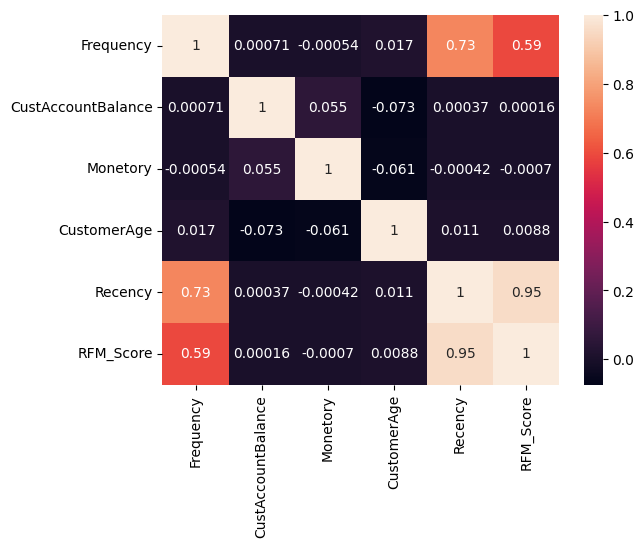

In [62]:
cor = eda.corr()
sns.heatmap(cor,annot=True)

<Axes: xlabel='Frequency', ylabel='count'>

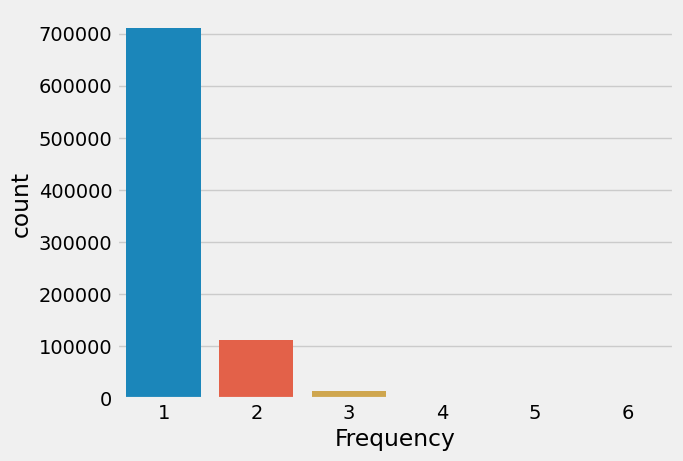

In [63]:
plt.style.use("fivethirtyeight")
sns.countplot(data = rfm_df, x='Frequency', order= eda['Frequency'].value_counts().index)

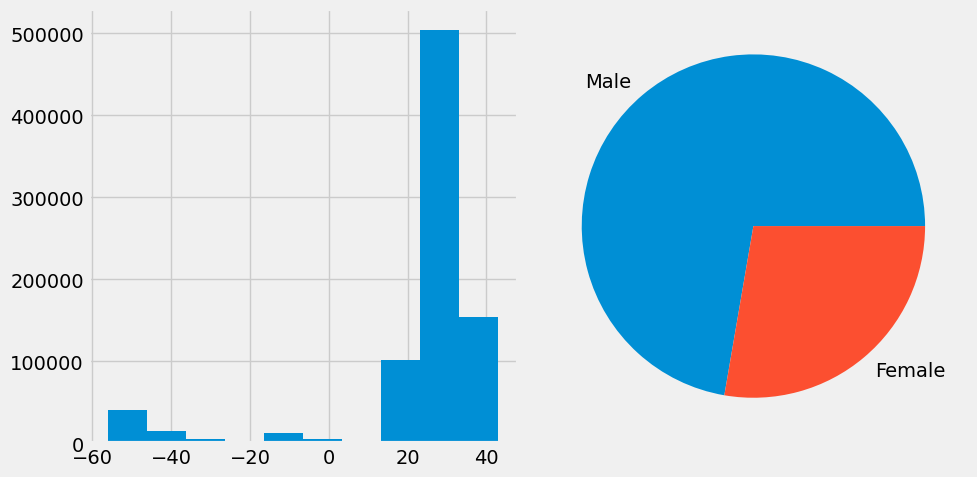

In [64]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
ax[0].hist(x=rfm_df['CustomerAge'])
ax[1].pie(rfm_df['CustGender'].value_counts(),labels=['Male','Female'])
plt.tight_layout()

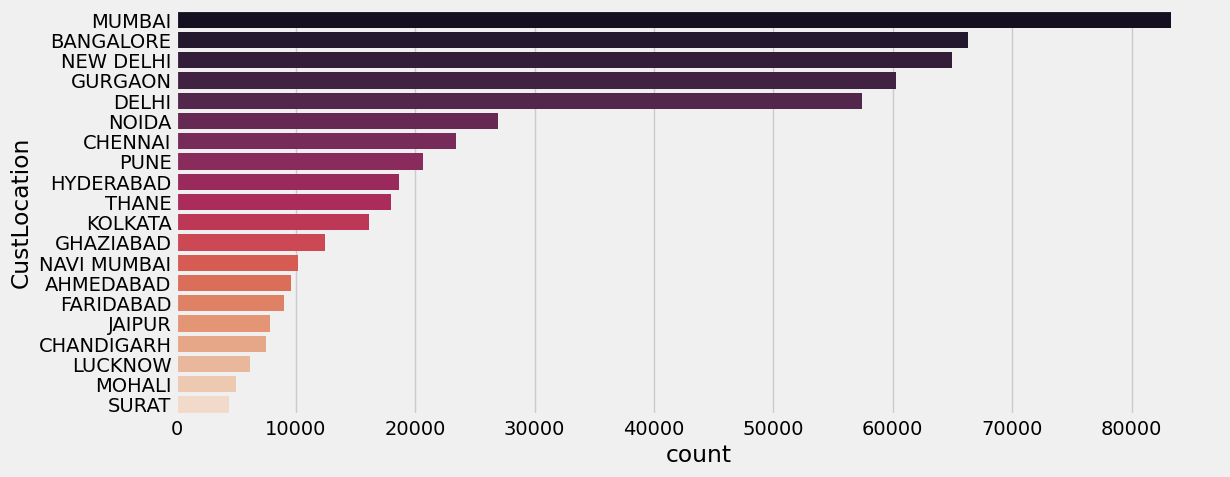

In [65]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,5))
chart=sns.countplot(y=rfm_df['CustLocation'], palette='rocket', order= rfm_df['CustLocation'].value_counts()[:20].index)

In [66]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Frequency           839081 non-null  int64         
 1   CustGender          839081 non-null  object        
 2   CustLocation        839081 non-null  object        
 3   CustAccountBalance  839081 non-null  float64       
 4   Monetory            839081 non-null  float64       
 5   CustomerAge         839081 non-null  float64       
 6   TransactionDate     839081 non-null  datetime64[ns]
 7   Recency             839081 non-null  int64         
 8   RFM_Score           839081 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(2)
memory usage: 54.4+ MB


<Axes: xlabel='Monetory', ylabel='CustAccountBalance'>

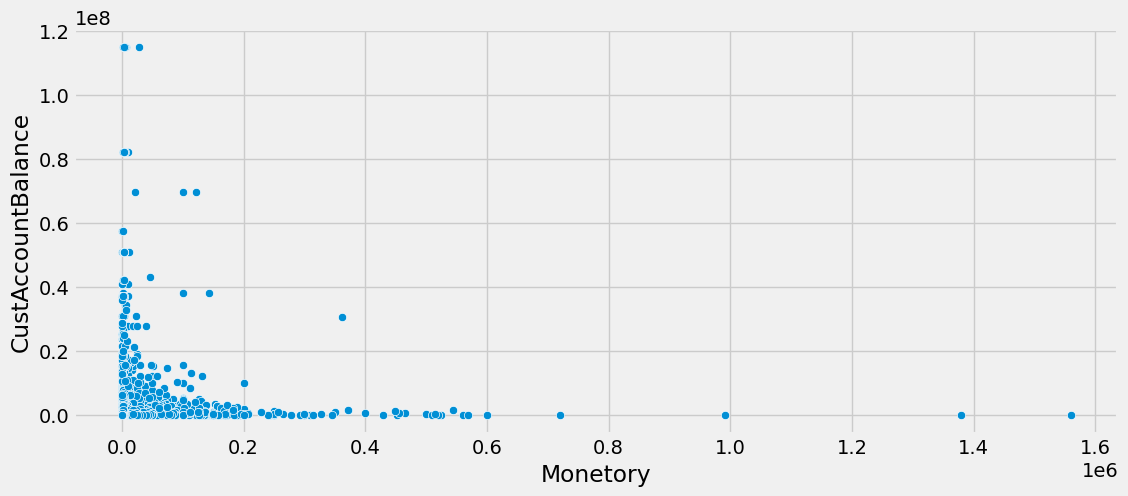

In [67]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,5))
sns.scatterplot(x=rfm_df['Monetory'], y=rfm_df['CustAccountBalance'])

## Feature Engineering

In [68]:
rfm_df.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,Monetory,CustomerAge,TransactionDate,Recency,RFM_Score
0,2,F,NOIDA,76340.635,2553.0,28.5,2016-09-17,18,144
1,1,M,MUMBAI,24204.490,1499.0,22.0,2016-08-14,1,144
2,2,F,MUMBAI,100112.950,727.5,28.0,2016-04-08,182,344
3,1,F,CHAMPARAN,496.180,30.0,26.0,2016-09-15,1,144
4,1,M,KOLKATA,87058.650,5000.0,-49.0,2016-08-18,1,144


In [69]:
rfm_df.drop(columns=['CustLocation','TransactionDate'],inplace=True)

In [70]:
rfm_df.head()

,Frequency,CustGender,CustAccountBalance,Monetory,CustomerAge,Recency,RFM_Score
0,2,F,76340.635,2553.0,28.5,18,144
1,1,M,24204.490,1499.0,22.0,1,144
2,2,F,100112.950,727.5,28.0,182,344
3,1,F,496.180,30.0,26.0,1,144
4,1,M,87058.650,5000.0,-49.0,1,144


In [71]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Frequency           839081 non-null  int64  
 1   CustGender          839081 non-null  object 
 2   CustAccountBalance  839081 non-null  float64
 3   Monetory            839081 non-null  float64
 4   CustomerAge         839081 non-null  float64
 5   Recency             839081 non-null  int64  
 6   RFM_Score           839081 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 41.6+ MB


In [72]:
rfm_df['CustGender'] = rfm_df['CustGender'].map({'M':1, 'F':0})

In [73]:
rfm_df.head()

,Frequency,CustGender,CustAccountBalance,Monetory,CustomerAge,Recency,RFM_Score
0,2,0,76340.635,2553.0,28.5,18,144
1,1,1,24204.490,1499.0,22.0,1,144
2,2,0,100112.950,727.5,28.0,182,344
3,1,0,496.180,30.0,26.0,1,144
4,1,1,87058.650,5000.0,-49.0,1,144


In [74]:
#data scaling

df_scaled = StandardScaler().fit_transform(rfm_df)
df_scaled = pd.DataFrame(df_scaled, columns= rfm_df.columns)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,Monetory,CustomerAge,Recency,RFM_Score
0,1.897629,-1.615225,-0.037537,0.181860,0.278847,0.062981,-0.250113
1,-0.400541,0.619109,-0.103847,0.007506,-0.027046,-0.310357,-0.250113
2,1.897629,-1.615225,-0.007302,-0.120116,0.255317,3.664598,4.557365
3,-0.400541,-1.615225,-0.134001,-0.235497,0.161196,-0.310357,-0.250113
4,-0.400541,0.619109,-0.023906,0.586644,-3.368340,-0.310357,-0.250113


In [75]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Frequency           839081 non-null  float64
 1   CustGender          839081 non-null  float64
 2   CustAccountBalance  839081 non-null  float64
 3   Monetory            839081 non-null  float64
 4   CustomerAge         839081 non-null  float64
 5   Recency             839081 non-null  float64
 6   RFM_Score           839081 non-null  float64
dtypes: float64(7)
memory usage: 44.8 MB


## Modeling

In [76]:
df_scaled=df_scaled.sample(n=100000,random_state=42).reset_index(drop=True)
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,Monetory,CustomerAge,Recency,RFM_Score
0,-0.400541,0.619109,-0.100958,-0.238805,0.067075,-0.310357,-0.250113
1,-0.400541,0.619109,-0.121610,-0.140066,0.349437,-0.310357,-0.250113
2,-0.400541,-1.615225,0.113488,-0.108123,0.631800,-0.310357,-0.250113
3,-0.400541,0.619109,-0.096452,-0.211014,0.255317,-0.310357,-0.250113
4,-0.400541,0.619109,-0.129578,-0.223917,0.349437,-0.310357,-0.250113


In [77]:
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}

inertias = []
silhouette_coefficients = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    score=silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

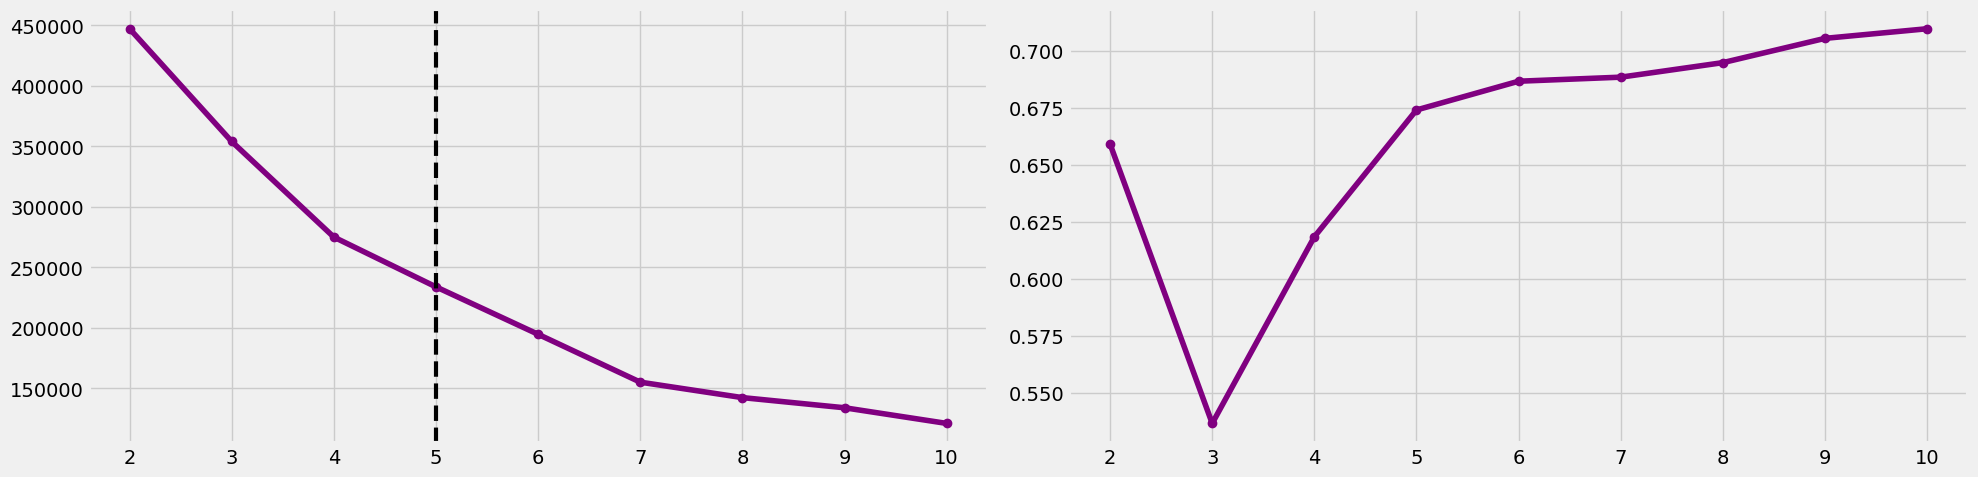

In [79]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11), inertias, curve='convex', direction="decreasing")
ax[0].plot(range(2,11), inertias,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

ax[1].plot(range(2,11), silhouette_coefficients,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))
plt.tight_layout();

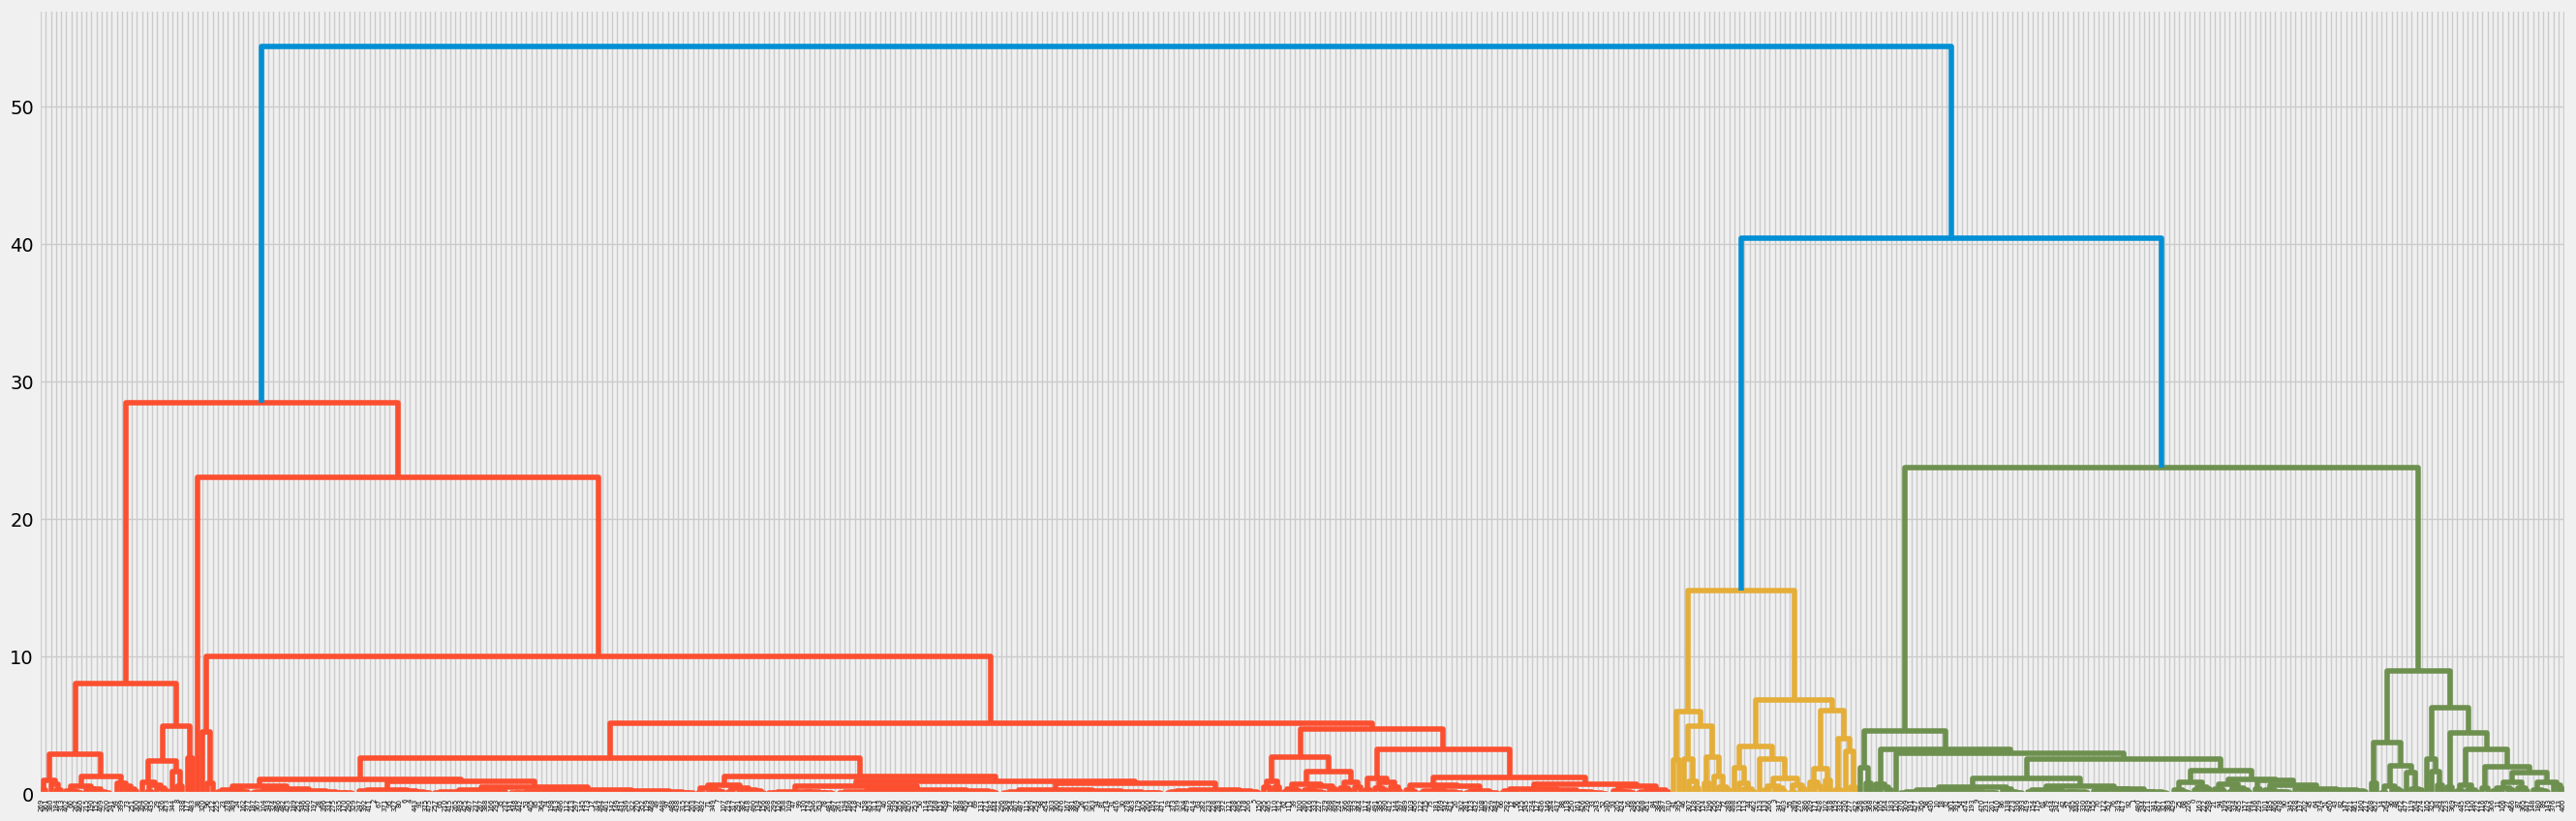

In [95]:
plt.figure(figsize=(30,10))
z = sch.linkage(df_scaled.iloc[:500,:], 'ward')
sch.dendrogram(z);

In [81]:
kmeans = KMeans(n_clusters=5 , **kmeans_set)    
kmeans.fit(df_scaled)
df_scaled['Label']=kmeans.labels_
df_scaled.head()

,Frequency,CustGender,CustAccountBalance,Monetory,CustomerAge,Recency,RFM_Score,Label
0,-0.400541,0.619109,-0.100958,-0.238805,0.067075,-0.310357,-0.250113,0
1,-0.400541,0.619109,-0.121610,-0.140066,0.349437,-0.310357,-0.250113,0
2,-0.400541,-1.615225,0.113488,-0.108123,0.631800,-0.310357,-0.250113,3
3,-0.400541,0.619109,-0.096452,-0.211014,0.255317,-0.310357,-0.250113,0
4,-0.400541,0.619109,-0.129578,-0.223917,0.349437,-0.310357,-0.250113,0


### PCA

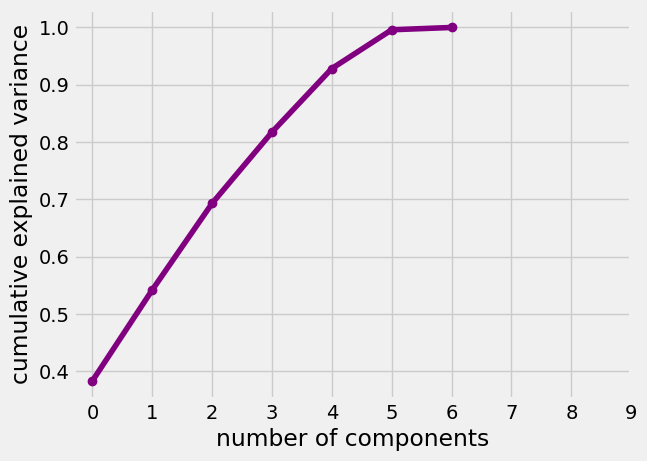

In [82]:
# here we want to check how many component we need to explain 90%  of the variance
pca = PCA().fit(df_scaled.iloc[:,:-1])
plt.plot(np.cumsum(pca.explained_variance_ratio_),color='purple',marker='o')  #EX: cusum([4,2,3,1,6]) ==>[4,6,9,10,16]
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xticks(np.arange(0, 10, 1))
plt.show()

In [91]:
#90% of varience representedd by 4 components

pca = PCA(n_components=4)
pca_data = pca.fit_transform(df_scaled.iloc[:,:-1])

inertia = []
silhouette = []


for k in range(2,11):
    km = KMeans(init='k-means++', n_clusters=k, random_state=42)
    km.fit(pca_data)
    inertia.append(km.inertia_)
    P_score=silhouette_score(pca_data, km.labels_)
    silhouette.append(P_score)

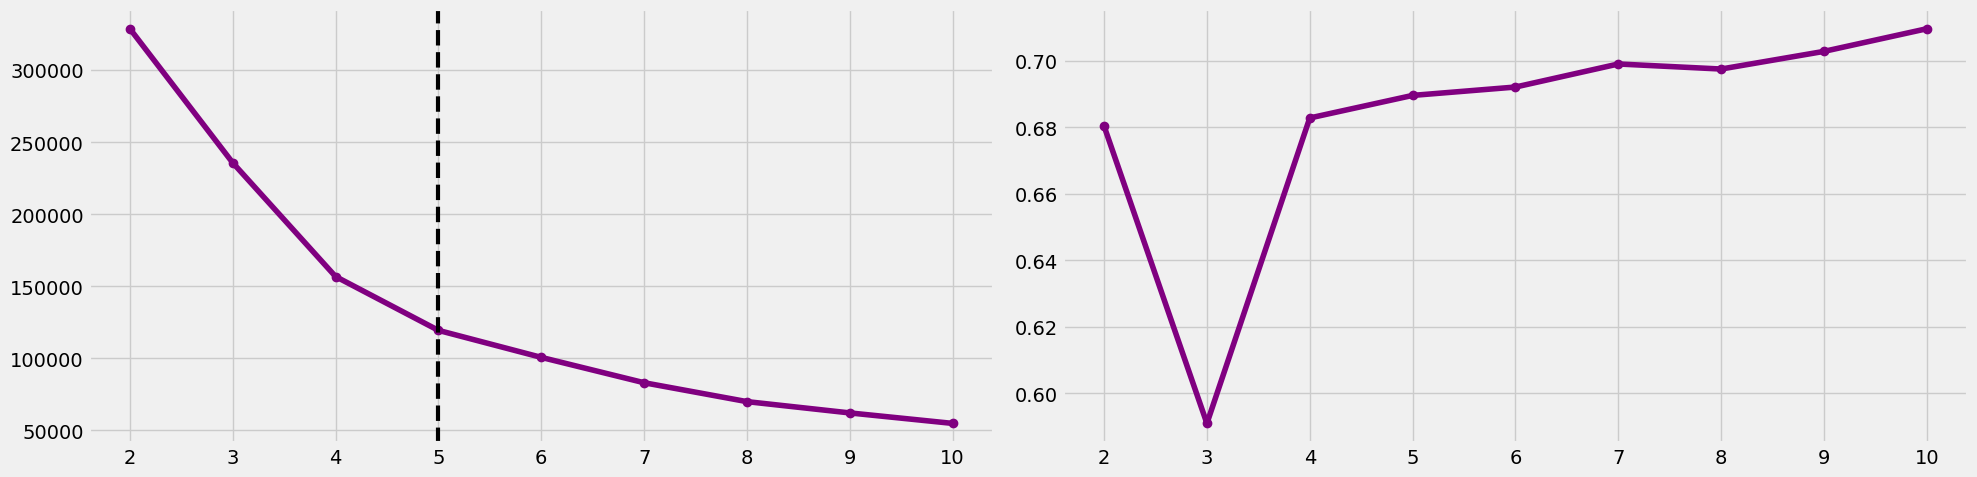

In [92]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
Pkl = KneeLocator(range(2,11), inertia, curve='convex', direction="decreasing")

# draw Elbow
ax[0].plot(range(2,11), inertia,color='purple',marker='o',label='Elbow Method')
ax[0].set_xticks(range(2,11))
ax[0].axvline(x=Pkl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)

# draw silhouette
ax[1].plot(range(2,11), silhouette,color='purple',marker='o',label='silhouette coefficients')
ax[1].set_xticks(range(2,11))

plt.tight_layout()

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [60.0, 60.0, 80.0, 80.0],
  [32.5, 32.5, 70.0, 70.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [95.0, 95.0, 112.5, 112.5],
  [51.25, 51.25, 103.75, 103.75],
  [15.0, 15.0, 77.5, 77.5],
  [5.0, 5.0, 46.25, 46.25],
  [145.0, 145.0, 155.0, 155.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [150.0, 150.0, 173.75, 173.75],
  [135.0, 135.0, 161.875, 161.875],
  [205.0, 205.0, 215.0, 215.0],
  [225.0, 225.0, 235.0, 235.0],
  [210.0, 210.0, 230.0, 230.0],
  [255.0, 255.0, 265.0, 265.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [260.0, 260.0, 282.5, 282.5],
  [245.0, 245.0, 271.25, 271.25],
  [220.0, 220.0, 258.125, 258.125],
  [148.4375, 148.4375, 239.0625, 239.0625],
  [25.625, 25.625, 193.75, 193.75],
  [315.0, 315.0, 325.0, 325.0],
  [345.0, 345.0, 355.0, 355.0],
  

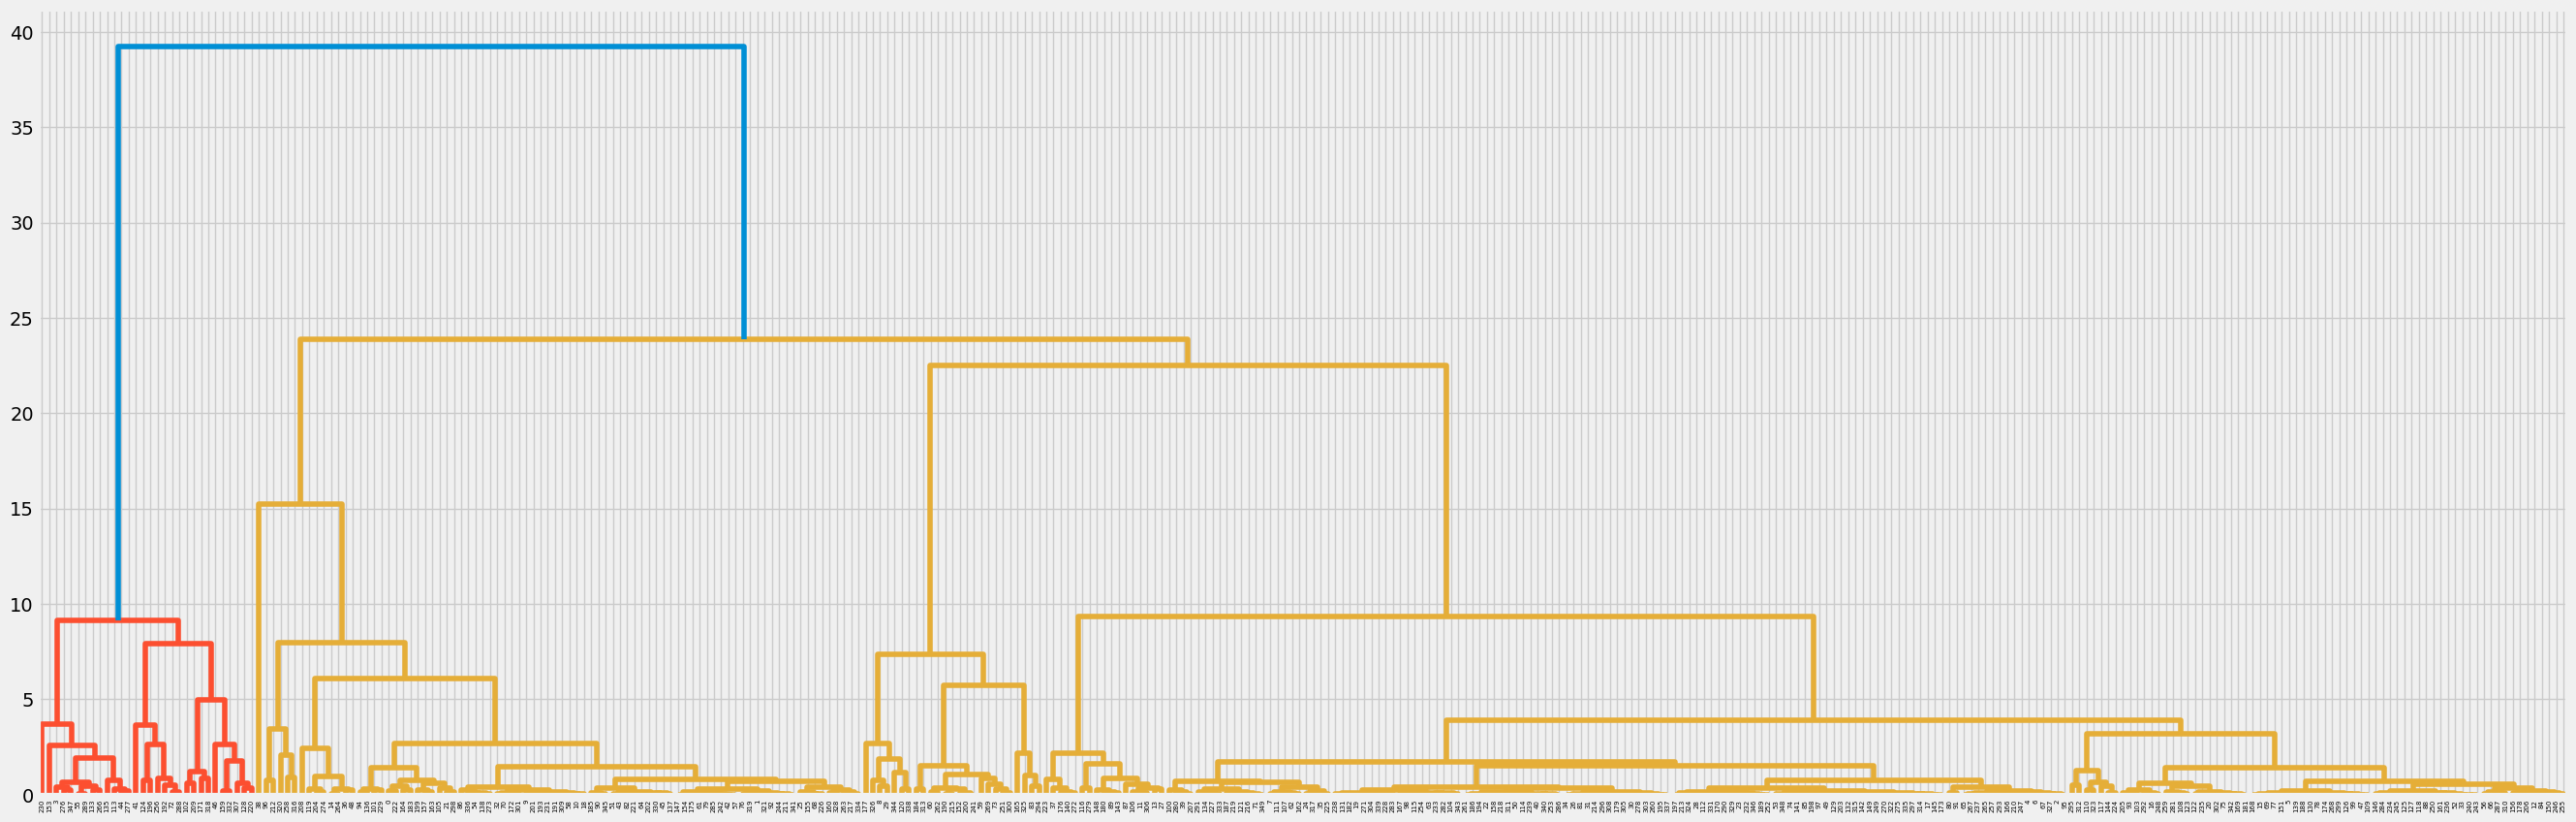

In [96]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,10))
z = sch.linkage(pca_data[:350,:], 'ward')
sch.dendrogram(z)

In [94]:
PCA_kmeans = KMeans(n_clusters=5 , **kmeans_set)    
PCA_kmeans.fit(pca_data)

# create a dataframe for the pca data
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['label'] = PCA_kmeans.labels_
pca_df.head()

,PC1,PC2,PC3,PC4,label
0,-0.545199,0.826231,-1.379346,0.419892,2
1,-0.545121,0.600398,-1.514385,-0.072889,2
2,-0.547370,-0.341321,0.519009,-0.241509,3
3,3.292318,-0.469133,0.462439,0.249062,1
4,-0.547953,-0.311473,0.535679,-0.277413,3
